# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

**The Business Problem and Goal** 

For the travel and booking industry, delays in flights can significantly impact customer satisfaction, specifically for delays in flights which are note expected by the consumers. The company discussed in the question is a travel booking website which is aiming to improve thier customer experience by predicting potential flight delays due to weather conditions. The business wants to proactively inform customers whether a flight may be delayed or not, to empower them to make more informed decision so that they can can plan their journey. 

**The Primary Business Problem which is being solved:** 

Consumers don't have prior knowledge whether their flights will be delayed or not due to weather and other reasons, this delay in flights can cause consumer dissatisfaction, this issue can be solved is a solution is created which can predict whether a flight will be delayed or not based on certain factors. 

**Machine Learning Problem Statement**

Using historical flight data that includes flight times, weather conditions, and delay status, this project aims to develop a binary classification model that can predict whether a flight will be delayed due to weather conditions. The model will classify flights as either "Delayed" or "Not Delayed."


This is a Supervised Learning problem, specifically a binary classification task, as there are labeled data indicating the delay status (delay vs. no delay) for each flight. This project will use historical flight data from 2014 to 2018 with weather features to train the model and make predictions on future flights.


### 2. Formulate the business problem, success metrics, and desired ML output.

**The Business Problem**

The goal is to improve customer experience for travelers booking flights on the said platform by providing timely alerts for potential delays due to weather. By accurately predicting if a flight is likely to be delayed, this can give customers actionable information during the booking process, allowing them to make adjustments to their travel plans and reduce frustration associated with unexpected delays.


**The Sucess Metrics of the Problem**

To evaluate the success of the specific machine learning model, the following metrics will be considered:

- Recall (Sensitivity) for the "Delay" class: Ensuring high recall is crucial, as we want to capture as many potential delays as possible to reduce the risk of undetected delays affecting customers.
- Precision for the "Delay" class: A reasonable precision score is essential to avoid over-alerting customers with false positives, which could lead to frustration if many predicted delays don’t occur.
- Area Under the ROC Curve (AUC-ROC): This metric will help evaluate the model's overall performance and its ability to discriminate between delayed and non-delayed flights across different thresholds.
- Accuracy: While less critical given the class imbalance, accuracy can still provide insight into overall model correctness.

**Desired ML Output**

The desired output of the machine learning model is a binary classification of each flight:

0: No Delay
    
1: Delay

Additionally, the model should produce probability scores that indicate the likelihood of a delay, enabling the company to set different thresholds for delay notifications based on operational needs or confidence levels.

In summary, the goal is to create a predictive model that:

- Alerts customers effectively when there’s a high probability of a flight delay.
    
- Minimizes false alerts by balancing precision and recall.

- Adds tangible value to the customer experience by reducing the impact of unexpected delays on travel plans.

A model that achieves these outcomes will enhance customer satisfaction, making the platform more appealing to travelers seeking reliable and proactive booking information.

### 3. Identify the type of ML problem you’re dealing with.

**Type of Machine Learning Problem**

This project is a supervised binary classification problem. The model is tasked with predicting whether a flight will be delayed (label = 1) or not delayed (label = 0) based on historical data that includes flight details, weather conditions, and other factors.

Key characteristics that make this a classification problem:

- Labeled Data: Each flight record in the dataset has a known outcome (delayed or not delayed), allowing the model to learn from past examples with labeled outcomes.

- Binary Output: The model’s objective is to classify each flight into one of two categories, "Delay" or "No Delay," based on the input features.

**Additionally, this classification problem is influenced by:**

Imbalanced Classes: The "No Delay" instances are much more common than "Delay" instances, which requires careful handling to improve recall for the minority "Delay" class without sacrificing overall precision.

In terms of machine learning paradigms, this problem fits into classification within supervised learning, as the goal is to assign a categorical label (delay or no delay) based on historical data.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>
from sklearn.model_selection import train_test_split


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [2]:
# download the files 

# All the zipfiles are stored in the data_compressed folder inside the data folder
zip_path = './data/data_compressed'
# The os.getcwd() returns the path to the directory where the script is running
# The working directory is saved as base_path 
base_path = os.getcwd()
# This line of code combines the base path with additional folders 
# This code creates the path for the folder where the csv files will be extracted 
csv_base_path = os.path.join(base_path, 'data', 'extracted_files')
# This code takes the "csv_base_path" path and creates the new folder extracted_files 
# All the extracted data will be stored in this file  
os.makedirs(csv_base_path, exist_ok=True)
# Printing where the csv files will be extracted to 
print("Files will be extracted to the directory:", csv_base_path)

Files will be extracted to the directory: f:\Jeem Poralekha\u3265713_DSTS_Assignment_2\Final Assignment Folder\data\extracted_files


In [3]:
# How many zip files do we have? write a code to answer it.

# This code creates a list of all the files and directories stored in zip_path folder which ends with .zip
# Here list comprehension has been used to filter on the zip files by combining with the endswith() method
zip_files_list = [file for file in os.listdir(zip_path) if file.endswith('.zip')]
# By using f string the lenth of the zip_file_count has been printed out. 
print(f"Total number of zip files: {len(zip_files_list)}")


Total number of zip files: 60


#### Extract CSV files from ZIP files

In [4]:
def zip2csv(zipFile_name, file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """
    """
    This function takes the name of the Zip file and a target folder path as inputs 
    It uses a try-except block to handle errors during extraction
    """

    try:
        # The code will atttmpt to open the Zip file in read-only mode ('r)
        with ZipFile(zipFile_name, 'r') as z: 
            # This print message will notify the user about the extractio of the current zip file 
            print(f'Extracting {zipFile_name}') 
            # This extracts the zip file z in the file_path 
            z.extractall(path=file_path) 
    # If there is an error during extraction, this will block the execution        
    except:
        # This will print the failed or the error message for the specified zip file 
        print(f'zip2csv failed for {zipFile_name}')

# Listing all files in the zip_path directory and filter for files that end with '.zip'
# os.path.join(zip_path, file): Joins the directory path and filename to form the full path for each ZIP file.
zip_files = [os.path.join(zip_path, file) for file in os.listdir(zip_path) if file.endswith('.zip')]
# Looping through each file in the zip_files folder and finally using the zip2csv to extract 
for file in zip_files:
    zip2csv(file, csv_base_path)
# After the loop is done the message "Files Extracted" will be printed 
print("Files Extracted")

Extracting ./data/data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
Extracting ./data/data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip
Extracting ./data/data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
Extracting ./data/data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
Extracting ./data/data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
Extracting ./data/data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip
Extracting ./data/data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip
Extracting ./data/data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip
Extracting ./data/data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip
Extracting ./data/data_compressed\On_Time_Reporting_Carrier_O

In [5]:
# How many csv files have we extracted? write a code to answer it.

# Creating a list of the csv files which are stored in the csv_base_path 
csv_files_list = [file for file in os.listdir(csv_base_path) if file.endswith('.csv')]
# Using f string and the len function printing the total number of csv files which were extracted. 
print(f"Number of CSV files extracted: {len(csv_files_list)}")

Number of CSV files extracted: 60


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [6]:
# from IPython.display import IFrame

# IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

In [7]:
# Importing the HTML display function from IPython to show the HTML here
from IPython.display import HTML
# Opening and displaying the HTML content directly
# Opening the HTML file in read mode ('r') as a file object 
with open(f"{csv_base_path}/readme.html", "r") as file:
    # Reading the entire content of the HTML file into a string variable
    html_content = file.read()
    #By using the display(HTML(..)) the entire HTML content has been rendered within the notebook 
    display(HTML(html_content))

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [8]:
# Defining the path to the sample csv file located in the extracted directory (csv_base_path)
# I just copied the name of the file from the question
csv_file_path = os.path.join(csv_base_path, 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv')
# Loading the the sample csv by using the file path created above 
df_temp = pd.read_csv(csv_file_path)
# Displaying the first few rows of the DataFrame
df_temp.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print the row and column length in the dataset, and print the column names.

In [9]:
# Printing the row and column length of the dataset

# Using the .shape attribute, to print the rows and columns  
df_shape = df_temp.shape
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [10]:
# Printing the first ten rows of the dataset

# By using the head method the first ten rows were printed
print(df_temp.head(10))

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2018        3      9           3          1  2018-09-03                9E   
1  2018        3      9           9          7  2018-09-09                9E   
2  2018        3      9          10          1  2018-09-10                9E   
3  2018        3      9          13          4  2018-09-13                9E   
4  2018        3      9          14          5  2018-09-14                9E   
5  2018        3      9          16          7  2018-09-16                9E   
6  2018        3      9          17          1  2018-09-17                9E   
7  2018        3      9          20          4  2018-09-20                9E   
8  2018        3      9          21          5  2018-09-21                9E   
9  2018        3      9          23          7  2018-09-23                9E   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     20363                

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [11]:
# Printing the column names of the dataframe 

# Printing a message to indicate the output of the column names 
print(f'The column names are :\n')
# Adding a seperator line for better readability in the output 
print('#########\n')
# Iterating over each column name which can be accessed by using .column attribute of pandas 
for col in df_temp.columns:
    print(col)

The column names are :

#########

Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Di

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [12]:
# Printing all the clumns in the dataset which contain the word "Del"

# Creating a list of the columns which contain the substring 'Del' in the names 
del_columns = [col for col in df_temp.columns if 'Del' in col]
# Printing the names of the columns that contain 'Del' 
print(f"Columns containing 'Del': {del_columns}")

Columns containing 'Del': ['DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'DivArrDelay']


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [13]:
# to answer above questions, the codes have been completed

# Printing Number of rows and columns in the temporary dataframe 
# .shape[0] gives the number of rows, .shape[1] gives the number of columns
print("The #rows and #columns are ", df_temp.shape[0], " and ", df_temp.shape[1])
# Printing the unique years in the 'Year' column to see the range of years in the dataset
# .unique() is used to list unique values present in the column
print("The years in this dataset are: ", df_temp['Year'].unique())
# Printing the unique months in the 'Month' column to identify which months are covered
# Using .unique() to get distinct month values in the dataset
print("The months covered in this dataset are: ", df_temp['Month'].unique())
# Printing the date range by finding the earliest and latest dates in 'FlightDate' column
# min() finds the earliest date, max() finds the latest date
print("The date range for data is:", min(df_temp['FlightDate']), " to ", max(df_temp['FlightDate']))
# Getting the list of airlines by getting the unique values in 'Reporting_Airline'
# Using .unique() to find all distinct airline codes
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
# Identifying the unique origin airports by finding the distinct values in 'Origin'
# .unique() provides a list of all unique origin airport codes
print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
# Identifying the unique destination airports by getting the distinct values in 'Dest' column
# .unique() is used to list all unique destination airport codes in the dataset
print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is: 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ'

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [14]:
# Creating a DataFrame that includes the counts of each airport in the 'Origin' and 'Dest' columns
# Using .value_counts() to get the count of occurrences for each unique value in the 'Origin' column
# Using .value_counts() to get the count of occurrences for each unique value in the 'Dest' column
counts = pd.DataFrame({
    'Origin': df_temp['Origin'].value_counts(), 
    'Destination': df_temp['Dest'].value_counts()
})

counts


,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [15]:
# Sorting the 'counts' DataFrame first by the 'Origin' column in descending order
# If there are ties in the 'Origin' counts, it then sorts by the 'Destination' column, also in descending order
# This combined sorting allows us to see airports ranked by origin first, then destination counts in case of a tie
# Displaying the top 15 rows after sorting to get the highest-ranking origin and destination airports
counts.sort_values(by=['Origin', 'Destination'], ascending=False).head(15)

,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Given all the information about a flight trip, including details about origin and destination airports, airlines, flight schedules, and weather conditions, we can use machine learning to predict whether a flight would be delayed. The dataset we’ve examined includes crucial features related to delays, such as departure and arrival times, delay minutes, and various types of delays (e.g., carrier delay, weather delay, etc.), along with other characteristics of each flight.

With this comprehensive dataset, we could build a predictive model. Key features that may influence flight delays include:

Scheduled departure and arrival times: Certain times of day or seasons may have higher delays.

Origin and destination airports: High-traffic airports may have a higher probability of delays.

Weather conditions: Weather delay information and location-specific weather can impact delays.

Airline: Different airlines may have varying performance and on-time rates.

Using this information, a classification model can be trained to predict whether a flight is likely to be delayed. By analyzing past data and identifying patterns, such a model can provide an estimated probability of delay, helping improve customer experience by offering insights during booking.

**-End of answer-**

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [16]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one DataFrame.
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    file_name: name of the file to save the combined DataFrame
    """
    # Creating an empty DataFrame to store the combined data from all CSV files 
    df = pd.DataFrame()
    # Looping through each CSV file in the provided list of files
    for file in csv_files:
        # Reading the current CSV file into a dataframe
        temp_df = pd.read_csv(file)
        # Filter the columns based on filter_cols variable which has been created above 
        # This filtering is being done on the temporary dataframe 
        temp_df_filtered = temp_df[filter_cols]
        # Applying row filtering for each subset column and subset values
        # Each col and vals pair is used to filter specific values in the DataFrame
        for col, vals in zip(subset_cols, subset_vals):
            temp_df_filtered = temp_df_filtered[temp_df_filtered[col].isin(vals)]
        # Concatenate the filtered temporary dataframe with the main dataframe
        # ignore_index=True reindexes the combined DataFrame to ensure continuity
        df = pd.concat([df, temp_df_filtered], ignore_index=True)
    # Save the final combined DataFrame to a CSV file with the given file name  
    df.to_csv(file_name, index=False)
    
    return df

In [17]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

# Creating a list of file paths for all CSV files in the 'csv_base_path' directory
csv_files = [os.path.join(csv_base_path, file) for file in os.listdir(csv_base_path) if file.endswith('.csv')]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [18]:
# Starting the timer
start = time.time()
# Defining the filename for the combined CSV
combined_csv_filename = f"{base_path}/combined_files.csv"
# Using the combine_csv function to merge all CSV files
combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)
# Printing the time taken to complete the merge
print(f'CSV files merged in {round((time.time() - start) / 60, 2)} minutes')

CSV files merged in 3.38 minutes


#### Load dataset

Load the combined dataset.

In [19]:
# Reading the new combined_files.csv 
data = pd.read_csv('combined_files.csv')

Print the first 5 records.

In [20]:
# Printing the first 5 records
# Using the head method  
data.head(5)


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,0.0,0.0,689.0,3,-20.0,0.0,0.0,99.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,0.0,0.0,731.0,3,-3.0,0.0,0.0,98.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,0.0,0.0,1199.0,5,-7.0,0.0,0.0,174.0
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,0.0,0.0,1587.0,7,-4.0,0.0,0.0,233.0
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,0.0,0.0,1587.0,7,-13.0,0.0,0.0,179.0


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [21]:
# to answer above questions, the following codes have been completed

# Printing the number of rows and columns in the dataset
# data.shape[0] provides the row count, and data.shape[1] gives the column count
print("The #rows and #columns are ", data.shape[0], " and ", data.shape[1])
# Getting the unique years included in the dataset from the 'Year' column
# .unique() is used to get all distinct years, and list() converts the output to a list format
print("The years in this dataset are: ", list(data['Year'].unique()))
# Fetching the unique months covered in the dataset from the 'Month' column
# .unique() gets all distinct months, sorted() arranges them in ascending order, and list() formats the output as a list
print("The months covered in this dataset are: ", sorted(list(data['Month'].unique())))
# Finding the date range in the dataset by looking at the earliest and latest dates in the 'FlightDate' column
# min() finds the earliest date, max() finds the latest date, providing the range
print("The date range for data is: ", min(data['FlightDate']), " to ", max(data['FlightDate']))
# Getting the unique airlines included in the dataset from the 'Reporting_Airline' column
# .unique() is used to get all distinct airline codes, and list() formats it as a list
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
# Fetching the unique origin airports from the 'Origin' column
# .unique() finds all unique origin airport codes, and list() converts the result to a list format
print("The Origin airports covered are: ", list(data['Origin'].unique()))
# Getting the unique destination airports from the 'Dest' column
# .unique() gets all unique destination airport codes, and list() formats the output as a list
print("The Destination airports covered are: ", list(data['Dest'].unique()))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is:  2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are:  ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are:  ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [22]:
# Rename the 'ArrDel15' column to 'is_delay'
data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True)

# Check if the renaming is done
# This will show the first few rows of the dataset with the updated column name
print(data.head())  

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX        2145        0.0       0.0   
1    DFW          TX  ATL        GA         945        0.0       0.0   
2    ATL          GA  DEN        CO        1855        0.0       0.0   
3    ATL          GA  PHX        AZ        1634        0.0       0.0   
4    PHX          AZ  ATL        GA         700        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  is_delay  AirTime  
0     689.0

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [23]:
# Check for null values across columns
null_counts = data.isnull().sum(axis=0)

# Print the count of nulls for each column
print(null_counts)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [24]:
# Remove rows where 'ArrDelay' or 'AirTime' are null
data = data[~data['ArrDelay'].isnull() & ~data['AirTime'].isnull()]

# Checking the null values agian in the dataset after removing null rows
print(data.isnull().sum(axis=0))

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64


Get the hour of the day in 24-hour time format from CRSDepTime.

In [25]:
# Extracting the hour of the day from CRSDepTime (assuming the format is HHMM)
data['DepHourofDay'] = data['CRSDepTime'] // 100

# Check the first few rows to confirm
print(data[['CRSDepTime', 'DepHourofDay']].head())

   CRSDepTime  DepHourofDay
0        2145            21
1         945             9
2        1855            18
3        1634            16
4         700             7


## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

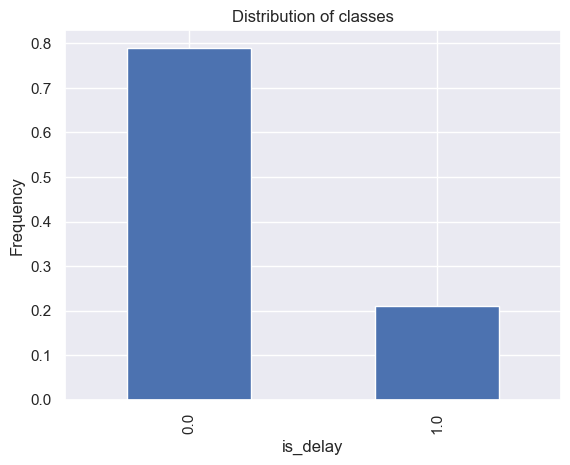

In [26]:
# Plot the distribution of the target variable 'is_delay'
(data.groupby('is_delay').size() / len(data)).plot(kind='bar')
# Set plot labels and title
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

From the plot, it can be ascertained that the frequency of class 0 (no delay) is higher than that of class 1 (delay). Class 0, representing flights without delays, has a frequency close to 0.8, while class 1, representing flights experiencing delays of more than 15 minutes, has a frequency around 0.2.

It implies that there are no delays in close to 77-80% of the flights while a little more than 20% of the flights experience of delays more than that of 15 minutes.  

Because the "No Delay" class is significantly more prevalent than the "Delay" class. 

Hence, there is a noticeable class imbalance present in the dataset. 

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

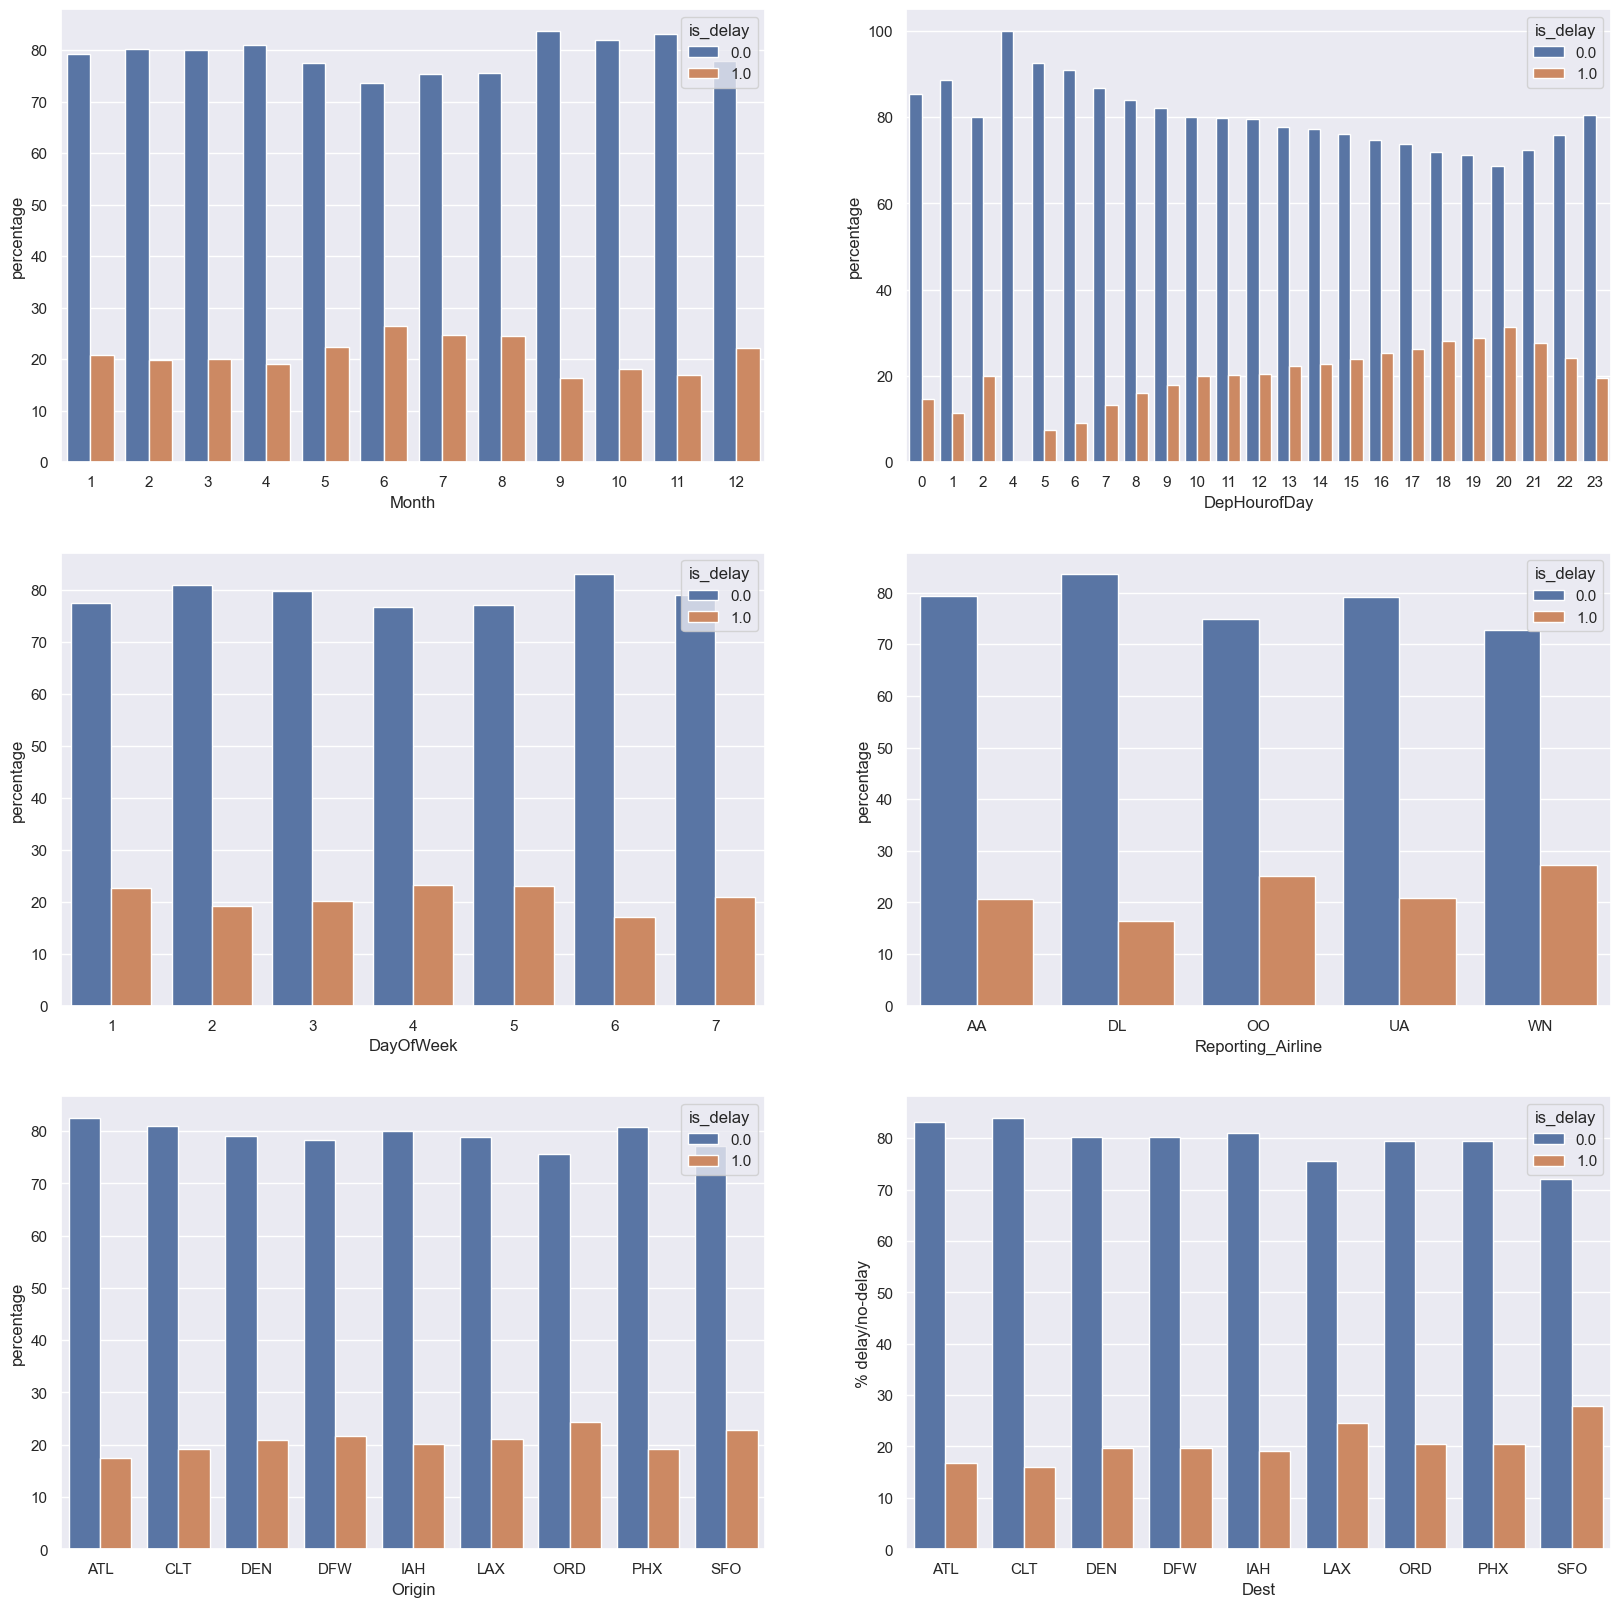

In [27]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

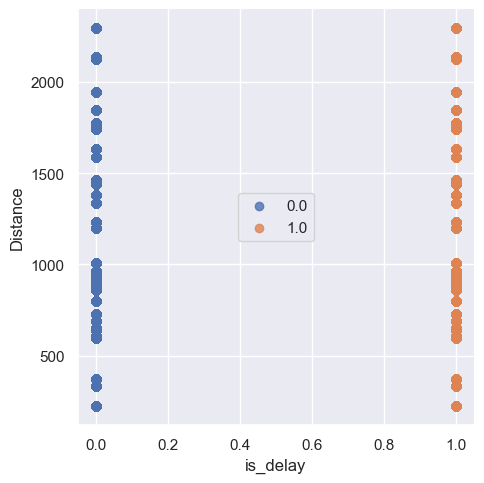

In [28]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

**Which months have the most Delays?**

From the first plot it can be deduced that, the delays (represented by is_delay = 1 in orange) is relatively consistant across all the months, but there is a slight increase in delays during the summer months in the USA namely (June to August), this due to the peak travel season during those months, from the plot it is evident that June experienced the highest number of delays compared to all other months in that time frame. Still now in the USA airlines experience more delays during the summer months. 

Source: https://www.cnbc.com/2024/08/05/summer-is-high-season-for-flight-delays-what-travelers-need-to-know.html#:~:text=Summer%20is%20generally%20peak%20season,make%20different%20obligations%20to%20travelers.


**What time of the day has most delays?**

The sub plot for DepHourOfDay in the first plot shows that delays of flights tend to increase as the day progresses furhter, peaking in the late afternoon and evening hours (from 15:00 to 20:00), where 20 (8pm to 9 pm) experiences the most delays (More than 30%) but the delays start dying down after 21 (9pm).

**What day of the week has the most delays?**
Delays appear to be fairly consistent across the days of the week, though there is a slight increment in the days 1, 4 and 5. If we consider 1 = Monday then 4 and 5 is Thursday and Friday respectively. Visually, the delays in these three days appear to be the same (A little more than 20% for all three days). Monday is the starting of the week, so it might mean more people flying thus there might be more flights which might cause a delay in that day. Similarly friday is the starting of weekends which means more people taking flights to go on a weekend break or going to meet their families which might lead to delays as well. 

**Which airline has the most delays?**
For the reporting airlines subplot it can be observed that WN and OO airlines seem to have a slightly higher proportion of delays compared to other airlines (More than 20%). But visually it can be seen that the bar chart for for WN is slightly taller than OO. So, we can conclude that in the data the flights form WN experienced the most delays. 

**Which origin and destination airports have the most delays?**
Origin Airport with Most Delays: From the plot, it is observed that ORD (Chicago O'Hare International Airport) has the highest proportion of delayed flights among the origin airports in the dataset.

Destination Airport with Most Delays: The plot also shows that SFO (San Francisco International Airport) experiences the highest proportion of delays among destination airports in the dataset.

Source: ORD and SFO are the airport codes of Chicago O'Hare International Airport & San Francisco International Airport, this information has been taken from google. 

**Is flight distance a factor in the delays?** 
The scatter plot for Distance vs. is_delay shows no clear pattern indicating that distance is a significant factor in delays. Both short and long-distance flights experience delays, suggesting that factors other than distance are more influential in determining delays.

### Features

Look at all the columns and what their specific types are.

In [29]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [30]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [31]:
# Creating a backup copy of the original data to keep it unchanged for future reference
data_orig = data.copy()
# Selecting only the columns needed for analysis and storing them in 'data'
data = data[['is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
             'Reporting_Airline', 'Origin', 'Dest', 'Distance', 'DepHourofDay']]
# Defining a list of columns that should be treated as categorical data types
categorical_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
# Looping over each column in 'categorical_columns' to convert them to a categorical data type
for c in categorical_columns:
    data[c] = data[c].astype('category')  # Changing column 'c' to categorical type for optimized storage and processing
# Defining the time ranges (in hours) to categorize 'DepHourofDay' into buckets
bins = [0, 6, 12, 18, 24]  # Hour intervals for bucketing: 0-6, 7-12, 13-18, 19-23
labels = ['0-6', '7-12', '13-18', '19-23']  # Labels corresponding to each time range
# Bucketizing 'DepHourofDay' using defined bins and labels, making it a categorical variable
# 'right=False' ensures that each bin includes the lower bound but excludes the upper bound, e.g., 0-6 includes 0 but excludes 6
data['DepHourofDay'] = pd.cut(data['DepHourofDay'], bins=bins, labels=labels, right=False)
# Displaying the first few rows of the modified dataset to verify that the changes have been applied correctly
print(data.head())

   is_delay Quarter Month DayofMonth DayOfWeek Reporting_Airline Origin Dest  \
0       0.0       1     1         26         7                DL    ATL  IAH   
1       0.0       1     1         26         7                DL    DFW  ATL   
2       0.0       1     1         26         7                DL    ATL  DEN   
3       0.0       1     1         26         7                DL    ATL  PHX   
4       0.0       1     1         26         7                DL    PHX  ATL   

   Distance DepHourofDay  
0     689.0        19-23  
1     731.0         7-12  
2    1199.0        19-23  
3    1587.0        13-18  
4    1587.0         7-12  


In [32]:
# Showing the each unique categories created for "DepHourofDay"
data['DepHourofDay'].unique()

['19-23', '7-12', '13-18', '0-6']
Categories (4, object): ['0-6' < '7-12' < '13-18' < '19-23']

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [33]:
# Performing one-hot encoding on the categorical columns 
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) 
# Concatenate the encoded categorical columns back with the main dataset
data = pd.concat([data, data_dummies], axis=1)
# Drop the original categorical columns as they are now represented in the encoded form
data.drop(categorical_columns, axis=1, inplace=True)


Check the length of the dataset and the new columnms.

In [34]:
data.shape

(1635590, 75)

In [35]:
data.columns

Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN',

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [36]:
# By using the .rename() function of Pandas the 'is_delay' column is renamed to 'target' for modeling purposes
data.rename(columns={'is_delay': 'target'}, inplace=True)
# Showing that the target column has been created
data['target']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1658125    0.0
1658126    0.0
1658127    1.0
1658128    0.0
1658129    0.0
Name: target, Length: 1635590, dtype: float64

In [37]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# note this combined file will be used in part B

# Defining the filename for the combined CSV file which will be saved in base path
combined_csv_filename_v1 = os.path.join(base_path, "combined_csv_v1.csv")
# Save the DataFrame as a CSV file to the specified location
data.to_csv(combined_csv_filename_v1, index=False)
# Printing the path where the file has been saved 
print(f"Combined CSV file saved to {combined_csv_filename_v1}")

Combined CSV file saved to f:\Jeem Poralekha\u3265713_DSTS_Assignment_2\Final Assignment Folder\combined_csv_v1.csv


# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [38]:
# Splitting the target variables and the independent variables
X = data.drop(columns=['target'])  # Features/Target variables stored as X
y = data['target']  # Target Variables stored as y
# Splitting into training and testing sets (80% train, 20% test) using the train_test_split function from sikitlearn 
# Here the stratify=y parameter has been used because y is imbalanced, this ensures that train and test sets have the same proportion of each class as in the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Print the shapes of resulting datasets to confirm whether the split has been done properly or not
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1308472, 74)
X_test shape: (327118, 74)
y_train shape: (1308472,)
y_test shape: (327118,)


### Baseline classification model

In [39]:
from sklearn.linear_model import LogisticRegression
# Initializng the basic logistic regression model with a fixed random state for reproducibility
log_reg = LogisticRegression(random_state=42)
# Fitting the logistic regression model on the training data (X_train, y_train)
log_reg.fit(X_train, y_train)
# Generate predictions for the test set using the trained model 
y_pred = log_reg.predict(X_test)
# Generating predictions on the training set to asses the model's fit on the training data
# This will be used to validate later
y_train_pred = log_reg.predict(X_train)

## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

A function for plotting Confusion Matrix is created below:

In [40]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    """ 
    This function will compute the confusion matrix and plot it as a heatmap to visualize
    the number of true positive, true negative, false positive, and false negative predictions.
    """
    # Generating the confusion matrix by using sklearns confusion matrix function
    cm = confusion_matrix(test_labels, target_predicted)
    
    # Plotting the confusion matrix as a heatmap
    # Setting the figure size
    plt.figure(figsize=(8, 6))
    # 'annot=True' adds counts to each cell, 'fmt' specifies integer format
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                # Setting the labels for x-axis and y-axis
                xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
    # Labeling the x-axis as "predicted" to indicate predicted classes 
    plt.xlabel('Predicted')
    # Labeling the y axis as actual
    plt.ylabel('Actual')
    # Showing the title
    plt.title('Confusion Matrix')
    plt.show()

A function for plotting ROC curve is given below:

In [41]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

def plot_roc(test_labels, target_probabilities):
    """
    Function to calculate and plot the ROC (Receiver Operating Characteristic) curve.
    This function calculates the False Positive Rate (FPR) and True Positive Rate (TPR) 
    to plot the ROC curve, which provides insight into the model's performance across 
    different classification thresholds. Additionally, it computes the AUC (Area Under 
    the Curve) to summarize the overall performance.
    """
    # Calculating False Positive Rate (FPR) and True Positive Rate (TPR)
    # Computing FPR and TPR at various threshold levels
    fpr, tpr, _ = roc_curve(test_labels, target_probabilities)  
    # Calculating the Area Under the Curve (AUC) as a single performance metric
    roc_auc = auc(fpr, tpr)  # AUC quantifies the overall ability to distinguish between classes
    # Plotting the ROC curve
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')  # Plots FPR vs TPR with AUC as label
    plt.plot([0, 1], [0, 1], linestyle='--')  # Adds a diagonal line for reference (random guess line)
    # Setting the x and y axis labels for clarity
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Adding a title to the plot
    plt.title('ROC Curve')
    # Adding a legend to display the AUC score on the plot
    plt.legend()
    # Display the ROC curve plot
    plt.show()

Creating a function to Generate Key performance metrics (Accuracy, precision and recall): 

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
def report_statistics(test_labels, target_predicted):
    """
    Function to calculate and report key performance metrics for a classification model.
    This function computes accuracy, precision, recall (sensitivity), and specificity 
    based on the true and predicted labels, providing a comprehensive view of the model's 
    performance across various metrics.
    """
    # Calculate Accuracy, Precision, and Recall
    accuracy = accuracy_score(test_labels, target_predicted)  # Overall accuracy of the model
    precision = precision_score(test_labels, target_predicted)  # Precision: proportion of true positives among predicted positives
    recall = recall_score(test_labels, target_predicted)  # Recall: proportion of true positives among actual positives (sensitivity)
    # Calculating Specificity
    # The .ravel() method extracts true negatives (tn), false positives (fp), false negatives (fn), and true positives (tp) from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(test_labels, target_predicted).ravel() 
    specificity = tn / (tn + fp)  # Specificity: proportion of true negatives among actual negatives
    # Print the calculated metrics in a formatted manner
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

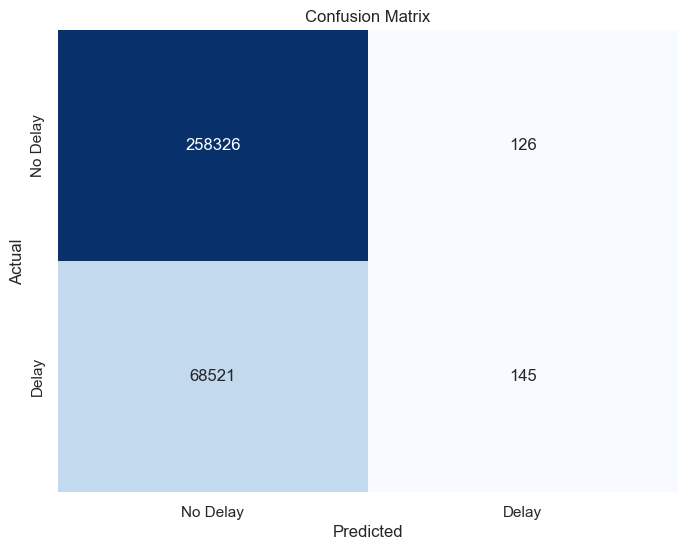

In [43]:
plot_confusion_matrix(y_test, y_pred)

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

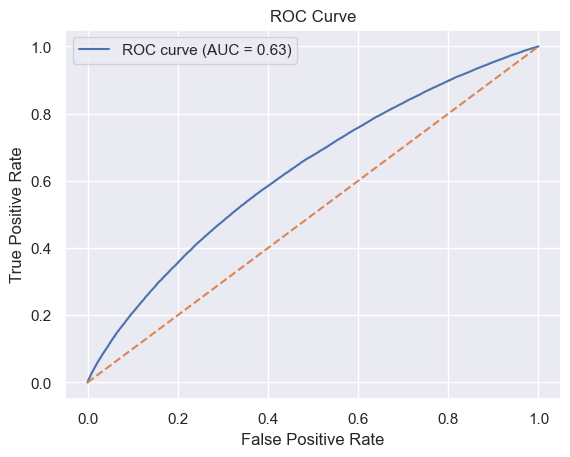

In [44]:
y_prob = log_reg.predict_proba(X_test)[:, 1] 
plot_roc(y_test, y_prob)

To print the performance metrics of the testing labels and the predicted labels 

In [45]:
report_statistics(y_test, y_pred)

Accuracy: 0.7901
Precision: 0.5351
Recall (Sensitivity): 0.0021
Specificity: 0.9995


Here the confusion matrix and key statistics have been generated by using the training data and the predictions made using the training data this is done to check whether the model has over fit or not. 

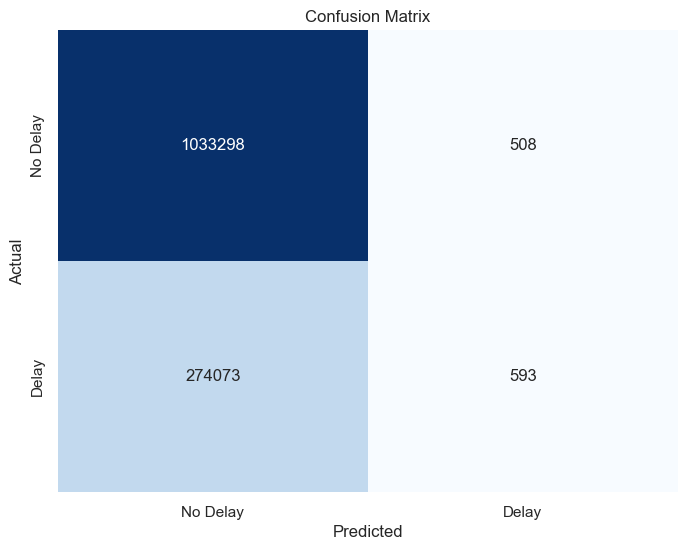

Accuracy: 0.7902
Precision: 0.5386
Recall (Sensitivity): 0.0022
Specificity: 0.9995


In [46]:

plot_confusion_matrix(y_train, y_train_pred)
report_statistics(y_train, y_train_pred)

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

#### Answer to Question 1: How does your model's performance on the test set compare to the training set? What can you deduce from this comparison?

Comparison: The performance metrics for the prediction on training and prediction on test sets are very similar:

- **Accuracy:** Accuracy measures the overall correctness of the model, calculated as the proportion of correctly predicted instances out of all instances. The accuracy for prediction on both the training and testing sets are approximately 79% for both the cases. This is high accuracy, however, this is primarily due to the class imbalance in the dataset. Since the majority of flights experience "No Delay," the model achieves high accuracy simply by correctly predicting the "No Delay" cases most of the time. This can be misleading because accuracy alone does not account for how well the model detects the minority class ("Delay" in this case).

The high accuracy here largely reflects the model’s ability to identify "No Delay" flights, not necessarily its effectiveness in predicting delays, which is the primary interest of this project. Therefore, focusing on additional metrics like precision, recall, and specificity is essential for evaluating the model's true effectiveness.

By Examining other metrics it can be observed that, 

- **Precision:** Precision is the proportion of true positive predictions (actual delays that were correctly predicted) out of all positive predictions made by the model (both true and false delays). The metric indicates that when the model predicts "Delay," it is correct about 53-54% of the time across both training and test sets. This shows that while the model is conservative in predicting delays, its predictions in this category are reasonably accurate.

- **Recall (Sensitivity):** Recall, or sensitivity, is the proportion of true positives (actual delays that were correctly predicted) out of all actual positive instances (all delays). Sensitivity is very low at around 0.0022% for both sets, meaning the model captures only a tiny fraction of actual delays. This low recall highlights that the model struggles significantly with the "Delay" class due to the imbalance, frequently failing to identify flights that actually experience delays.

- **Specificity:** Specificity measures the proportion of true negatives (actual non-delays that were correctly predicted) out of all actual negative instances (all non-delays). Specificity is nearly perfect at about 99.95% for both training and test sets, indicating that the model is highly effective at correctly predicting "No Delay" flights with very few false positives. This is because there is a very high number of non-delays and the model is trained well to determine no delays 

**Conclusion:**

The metrics indicate that the model is highly effective at identifying the "No Delay" class due to the dataset’s imbalance, where "No Delay" cases dominate. This is evident in the model’s high specificity (99.95%) and low recall (0.2%) for the "Delay" class. The high accuracy (~79%) and specificity suggest that the model reliably identifies "No Delay" flights, but the extremely low recall indicates that it frequently fails to detect actual delays.

The consistency between training and test set metrics (both showing high accuracy and specificity, but low recall) suggests that the model is not overfitting. Instead, it reflects the impact of the class imbalance, where the model prioritizes "No Delay" predictions due to the prevalence of that class in the data. This results in a model that performs well on "No Delay" cases but has limited effectiveness for predicting delays, which is likely our main area of interest.

To address this issue, techniques for handling class imbalance (such as resampling methods, class-weight adjustments, or alternative algorithms) could help improve the model’s ability to identify delays. Such adjustments would make the model more balanced, better suited to applications where accurately predicting delays is crucial from a business standpoint, as it would consider both classes more equitably.

**Sources:** 

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2023). An introduction to statistical learning (2nd ed.). Springer.

Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: A guide for data scientists. O'Reilly Media.

#### Answer to Question 2: Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences?

Yes, there are clear differences between the outcomes of metrics like accuracy, precision, and recall, which are influenced primarily by the class imbalance in the dataset.

- The accuracy is relatively high at 79%, which may suggest the model performs well at first glance. However, this high accuracy is largely due to the model's effectiveness in identifying "No Delay" instances, which dominate the dataset.

- Precision (53.51%) indicates that when the model does predict a delay, it is correct slightly more than half the time. However, the precision alone doesn’t fully capture the model's limitations, as it rarely predicts "Delay" due to the class imbalance.

- The recall is extremely low (0.21%), highlighting that the model fails to capture most actual delays. This low recall is a major limitation, as it suggests the model is missing almost all delayed flights.

The differences among these metrics—especially between high accuracy and low recall—highlight the model's bias towards the "No Delay" class due to class imbalance. This bias results in high accuracy and specificity but comes at the cost of extremely low recall, making the model unreliable for detecting actual delays.

In a business context where identifying delays is important, these metric differences suggest that the model needs improvement to better capture the minority "Delay" class. Handling the class imbalance through resampling methods, adjusting class weights, or exploring alternative models could help balance these metrics, particularly to improve recall without sacrificing too much precision.



#### Answer to Question 3: Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

By looking at a business perspective, the key metric for this specific business problem (accurately predicting flight delay) would be recall. The outcome for the key metric—recall, which is critical for identifying delays—is not sufficient from a business standpoint. Given the model's low recall, it would struggle to accurately predict delays, which could lead to missed opportunities for proactive customer communication or operational adjustments.

**Importance of recall in this specific business problem:**

Accurately identifying delayed flights (high recall) is crucial specifically for an online booking website. A model with high recall would help in taking timely actions, such as notifying passengers, rebooking, and managing resources more effectively to minimize inconvenience.

Addressing Class Imbalance:

- Resampling Techniques: Try oversampling the minority class (delayed flights) or undersampling the majority class (non-delayed flights) to create a more balanced training set.
- Synthetic Data Generation: Use methods such as SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic examples of delayed flights.

Feature Engineering:

- Additional Weather Features: Adding specific weather data (such as storm forecasts, precipitation, or visibility) for origin and destination airports could improve delay predictions.
- Time-Based Features: Incorporate features that capture time trends, such as peak travel hours or seasonal delays, to provide context around busier periods with a higher likelihood of delays.

Model Tuning and Alternative Algorithms:

- Hyperparameter Tuning: Experiment with different hyperparameters in logistic regression to see if model performance can be improved.
- Alternative Models: Explore more advanced models like decision trees, random forests, or gradient boosting, which might capture complex relationships in the data better than logistic regression.

Improving recall while maintaining reasonable precision and specificity is critical for the model’s success. Making these adjustments would increase the model’s reliability, ensuring that delay notifications are as accurate and helpful as possible for customers

**Sources**

Resampling: https://www.kdnuggets.com/2023/02/role-resampling-techniques-data-science.html#:~:text=Resampling%20is%20a%20method%20that,accuracy%20and%20estimate%20the%20uncertainty.

SMOTE: https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

Feature Engineering: https://github.com/tomeryosef/Data-Science-FLIGHT-DELAY-PREDICTION-HIT

Tuning of Models and other algorithms: https://github.com/pranaykmr/FlightDelayPrediction



#### **Question**: What can you summarize from the confusion matrix?


From the confusion matrix, we can make the following observations:

- True Positives (Delay Correctly Predicted): There are 145 true positive cases, where the model correctly predicted "Delay." This is a very small number compared to the total number of delays, indicating that the model struggles to identify delays accurately.

- True Negatives (No Delay Correctly Predicted): There are 258,326 true negatives, where the model correctly predicted "No Delay." This high number shows that the model is very good at identifying flights with "No Delay."

- False Positives (No Delay Incorrectly Predicted as Delay): There are 126 false positives, meaning the model predicted "Delay" for flights that were actually "No Delay." This number is very low, which indicates that the model rarely raises false alarms for delays.

- False Negatives (Delay Incorrectly Predicted as No Delay): There are 68,521 false negatives, where the model predicted "No Delay" for flights that were actually "Delay." This large number highlights the model's significant issue with missing actual delay cases, which leads to a low recall.

**Summary**

The confusion matrix reveals that the model heavily favors predicting "No Delay" due to the imbalanced nature of the data. While it achieves high accuracy in predicting "No Delay," it performs poorly in detecting actual delays, as evidenced by the high false negatives. This imbalance indicates that the model is likely biased towards the majority class ("No Delay") and lacks sensitivity for detecting the minority class ("Delay"), which is crucial for improving delay prediction reliability.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


### Provide a link for your Gitlab repository here:



# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [47]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig["is_holiday"] = data_orig["FlightDate"].isin(holidays)

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [48]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [49]:
weather = pd.read_csv("data/daily-summaries-2024-10-30T08-47-08.csv") # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
# Creating a dictionary to map the weather station codes to airport codes
station_map = dict(zip(station, airports))
# Map the 'station' column in the weather DataFrame to airport codes using the station_map
weather['airport'] = weather['STATION'].map(station_map)

Create another column called `MONTH` from the `DATE` column.

In [50]:
# Extracting the month part from the 'DATE' column
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1]) 
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [51]:
weather['SNOW'].unique()

array([ nan,   0.,   3.,  15.,  56.,  81.,   5.,  91.,  43.,  58.,   8.,
        20.,  25.,  41.,  13.,  36.,  18.,  86.,  10., 137.,  46.,  76.,
        23.,  97., 152.,  79.,  53.,  74.,  48., 104.,  89.,  30.,  71.,
        33., 196., 175., 119., 333., 300.,  51.,  38., 107.,  66.,  61.,
       145.,  69., 147., 221.,  28.,  64., 127.,  94., 411., 142., 178.,
       163., 130.,  99., 157.,  84., 117.])

In [52]:
weather['SNWD'].unique()

array([ nan,   0.,  30.,  50.,  80., 100., 150., 230., 130., 180., 250.,
       200., 280., 300., 330., 360., 460., 430., 410., 380.,  25.,  51.])

It is being assumed that NaN values in the SNOW and SNWD columns indicate the absence of snowfall or snow depth, so we will replace these missing values with zero.

In [53]:
weather.SNOW.fillna(0, inplace=True)  
weather.SNWD.fillna(0, inplace=True)  
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [54]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = idx[weather["TAVG"].isna()]
TMAX_idx = idx[weather["TMAX"].isna()]
TMIN_idx = idx[weather["TMIN"].isna()]
idx

array([    0,     1,     2, ..., 16431, 16432, 16433])

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [55]:
# Grouping by "STATION" and "MONTH" allows us to calculate monthly average values 
# for TAVG, TMAX, and TMIN specific to each station. This approach ensures that 
# missing values are filled with averages that reflect both seasonal variation 
# and the unique climate conditions at each airport station. This makes the 
# imputation more accurate than using a single average across all data.
weather_impute = (weather.groupby(["STATION", "MONTH"]).agg({"TAVG": "mean", "TMAX": "mean", "TMIN": "mean"}).reset_index())
# Display the first few rows to check that the aggregation is successful
weather_impute.head(2)

,STATION,MONTH,TAVG,TMAX,TMIN
0,USW00003017,01,-2.741935,74.000000,-69.858065
1,USW00003017,02,11.219858,88.553191,-65.035461


Merge the mean data with the weather data.

In [56]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [57]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [58]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [59]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [60]:
sum(data.isna().any())

0

In [61]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [62]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]

# I have added departure hours of the day as a categorical column here 
categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [63]:
# Defining the time ranges (in hours) to categorize 'DepHourofDay' into buckets
bins = [0, 6, 12, 18, 24]  # Hour intervals for bucketing: 0-6, 7-12, 13-18, 19-23
labels = ['0-6', '7-12', '13-18', '19-23']  # Labels corresponding to each time range
# Bucketizing 'DepHourofDay' using defined bins and labels, making it a categorical variable
# 'right=False' ensures that each bin includes the lower bound but excludes the upper bound, e.g., 0-6 includes 0 but excludes 6
data['DepHourofDay'] = pd.cut(data['DepHourofDay'], bins=bins, labels=labels, right=False)
# Displaying the first few rows of the modified dataset to verify that the changes have been applied correctly
print(data.head())

   is_delay  Year Quarter Month DayofMonth DayOfWeek Reporting_Airline Origin  \
0       0.0  2014       1     1         26         7                DL    ATL   
1       0.0  2014       1     1         26         7                DL    DFW   
2       0.0  2014       1     1         26         7                DL    ATL   
3       0.0  2014       1     1         26         7                DL    ATL   
4       0.0  2014       1     1         26         7                DL    PHX   

  Dest  Distance DepHourofDay is_holiday  AWND_O  PRCP_O  TAVG_O  AWND_D  \
0  IAH     689.0        19-23      False      33       0    54.0      30   
1  ATL     731.0         7-12      False      39       0   136.0      33   
2  DEN    1199.0        19-23      False      33       0    54.0      77   
3  PHX    1587.0        13-18      False      33       0    54.0      20   
4  ATL    1587.0         7-12      False      20       0   165.0      33   

   PRCP_D  TAVG_D  SNOW_O  SNOW_D  
0       0   130.0   

In [64]:
# Perform one-hot encoding on the specified categorical columns and drop the first level for dummy encoding
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)

# Concatenate the encoded columns with the original dataset
data = pd.concat([data, data_dummies], axis=1)

# Remove the original categorical columns since they are now represented in encoded form
data.drop(categorical_columns, axis=1, inplace=True)

# Display the first few rows to verify the transformation
data.head()

,is_delay,Distance,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,SNOW_D,...,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True,DepHourofDay_7-12,DepHourofDay_13-18,DepHourofDay_19-23
0,0.0,689.0,33,0,54.0,30,0,130.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,True
1,0.0,731.0,39,0,136.0,33,0,54.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
2,0.0,1199.0,33,0,54.0,77,0,68.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,0.0,1587.0,33,0,54.0,20,0,165.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
4,0.0,1587.0,20,0,165.0,33,0,54.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False


### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [65]:
data.columns

Index(['is_delay', 'Distance', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015', 'Year_2016',
       'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOf

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [66]:
data.rename(columns={"is_delay": "target"}, inplace=True) 

In [67]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B

# Defining the filename for the new combined CSV file to be saved in base path
combined_csv_filename_v2 = os.path.join(base_path, "combined_csv_v2.csv")
# Saving the DataFrame as a CSV file to the specified location
data.to_csv(combined_csv_filename_v2, index=False)
# Printing the path where the file has been saved
print(f"New combined CSV file saved to {combined_csv_filename_v2}")

New combined CSV file saved to f:\Jeem Poralekha\u3265713_DSTS_Assignment_2\Final Assignment Folder\combined_csv_v2.csv


Create the training and testing sets again.

In [68]:
# Splitting the target variables and the independent variables
X = data.drop(columns=['target'])  # Features/Target variables stored as X
y = data['target']  # Target Variables stored as y
# Splitting into training and testing sets (80% train, 20% test) using the train_test_split function from sikitlearn 
# Here the stratify=y parameter has been used because y is imbalanced, this ensures that train and test sets have the same proportion of each class as in the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Print the shapes of resulting datasets to confirm whether the split has been done properly or not
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1308472, 87)
X_test shape: (327118, 87)
y_train shape: (1308472,)
y_test shape: (327118,)


### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [69]:
# Initializing another logistic regression model with a fixed random state for consistency
classifier2 = LogisticRegression(random_state=42)
# Fitting the new logistic regression model on the training data (X_train, y_train)
classifier2.fit(X_train, y_train)
# Generating predictions for the test set using the new trained model
y_pred2 = classifier2.predict(X_test)

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

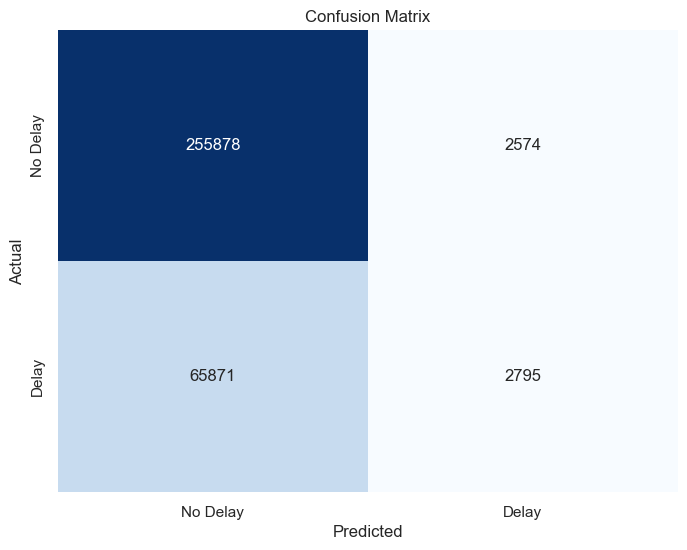

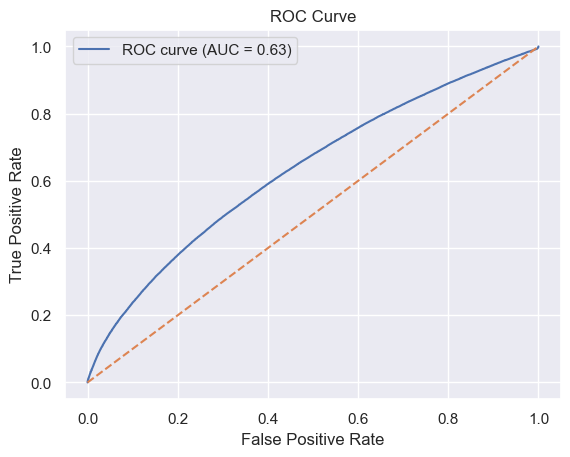

Accuracy: 0.7908
Precision: 0.5206
Recall (Sensitivity): 0.0407
Specificity: 0.9900


In [70]:
# Generate the probability predictions for the test set using classifier2
y_prob2 = classifier2.predict_proba(X_test)[:, 1] 

# Plot the confusion matrix for the new predictions
plot_confusion_matrix(y_test, y_pred2)

# Plot the ROC curve for the new predictions
plot_roc(y_test, y_prob2)

# Print the performance metrics for the new predictions
report_statistics(y_test, y_pred2)

### Question: did you notice a difference by adding the extra data on the results?

### Comparison of Model Performance with and without Additional Features

In this section, we evaluate the impact of adding additional features (weather and holiday indicators) on the model's performance metrics. Below is a table comparing the key metrics between the original model and the improved model with added features.

| Metric                   | Model 1 (Original) | Model 2 (With Additional Features) | Difference |
|--------------------------|--------------------|-------------------------------------|------------|
| **Accuracy**             | 0.7901            | 0.7908                             | +0.0007    |
| **Precision**            | 0.5351            | 0.5206                             | -0.0145    |
| **Recall (Sensitivity)** | 0.0021            | 0.0407                             | +0.0386    |
| **Specificity**          | 0.9995            | 0.9900                             | -0.0095    |
| **AUC**                  | 0.63              | 0.63                               | 0.00       |

### Observations and Analysis

**Accuracy:** 
- Both models achieve a similar accuracy of around 79%. However, this high accuracy is largely due to the class imbalance in the dataset, where "No Delay" cases are dominant. As observed in the first question’s insights, this accuracy is primarily driven by the model’s ability to correctly identify "No Delay" instances, which does not necessarily indicate its effectiveness in predicting delays.
- The minimal change in accuracy between the models suggests that the additional features did not significantly alter the model’s overall correctness, which is heavily influenced by the predominant "No Delay" class.

**Precision:** 
- Precision slightly decreased in Model 2 (from 0.5351 to 0.5206). This means that when Model 2 predicts "Delay," it is correct only about half of the time. The decrease in precision indicates that Model 2 produces more false positives (incorrectly predicting delays) with the added features.
- However, this drop in precision may be a trade-off to improve recall, as Model 2 attempts to capture more actual delay cases.

**Recall (Sensitivity):** 
- Recall shows a modest improvement from 0.0021 to 0.0407. Despite this increase, the recall is still very low due to the significant class imbalance. A recall of 0.0407 means that the model still misses the majority of actual delay cases.
- This slight increase in recall indicates that Model 2 is somewhat better at capturing delays than Model 1, but the improvement is not substantial. Further handling of class imbalance might be needed to achieve meaningful recall gains.

**Specificity:** 
- Specificity remains high for both models, though it slightly decreases in Model 2 (from 0.9995 to 0.9900). The high specificity indicates that both models are very effective at identifying "No Delay" flights, with Model 1 being slightly more conservative in this respect.
- The small reduction in specificity in Model 2 reflects the model's shift in focus to capture some delay cases, which slightly impacts its performance on "No Delay" cases.

**AUC (Area Under the Curve):**
- Both models have a similar AUC of 0.63, indicating that the discrimination capability remains the same between the two models. This suggests that the added features have not significantly impacted the model's ability to differentiate between delayed and non-delayed flights.

### Conclusion

Yes, adding extra data slightly improved the recall (sensitivity), making Model 2 better at identifying delay cases than Model 1. However, the improvement was limited, likely due to the underlying class imbalance, which remains a significant challenge. This suggests that further handling of class imbalance, such as resampling techniques or adjusting class weights, may be necessary to meaningfully improve recall and create a model more suited for predicting delays effectively.

# Additional Section: In this section the class imbalance will be solved and a new model will be created and then the results for all the models will be compared 

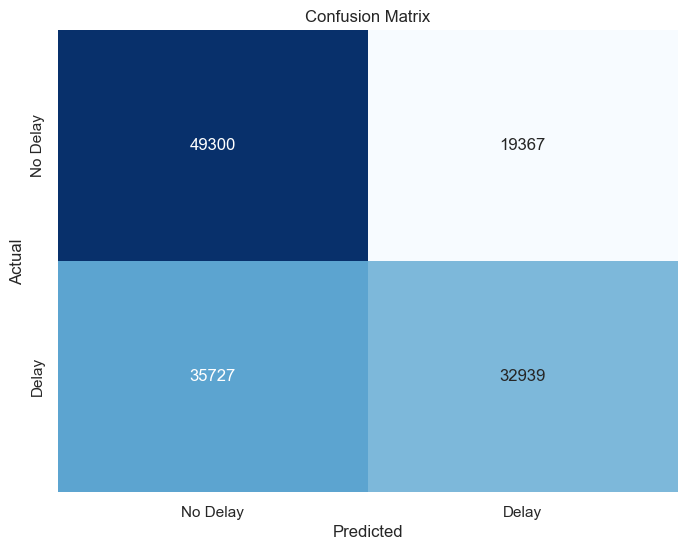

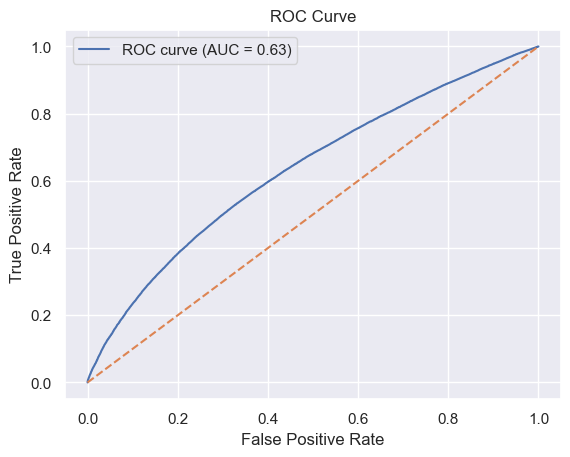

Accuracy: 0.5988
Precision: 0.6297
Recall (Sensitivity): 0.4797
Specificity: 0.7180


In [71]:
# Creating a balanced sample dataset with equal parts "Delay" and "No Delay" instances
# Separating the delay and no delay instances from the main data file 
delay_instances = data[data['target'] == 1]  # Selecting rows where target is "Delay"
no_delay_instances = data[data['target'] == 0]  # Selecting rows where target is "No Delay"
# Undersample the "No Delay" instances to match the number of "Delay" instances
no_delay_sample = no_delay_instances.sample(n=len(delay_instances), random_state=42)
# Combine the delay instances with the undersampled no delay instances
sampled_data = pd.concat([delay_instances, no_delay_sample], axis=0)
#Defining features and target for the sampled data
X_sample = sampled_data.drop(columns=['target'])  # Features
y_sample = sampled_data['target']  # Target
# Splitting the sampled data into training and testing sets (80% train, 20% test)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)
# Training a baseline logistic regression model on the sampled dataset
log_reg_sample = LogisticRegression(random_state=42)
log_reg_sample.fit(X_train_sample, y_train_sample)
# Generating predictions and probabilities for the test set
y_pred_sample = log_reg_sample.predict(X_test_sample)
y_prob_sample = log_reg_sample.predict_proba(X_test_sample)[:, 1]
# Evaluating the model using the existing functions
# Plot the confusion matrix
plot_confusion_matrix(y_test_sample, y_pred_sample)
# Plot the ROC curve
plot_roc(y_test_sample, y_prob_sample)
# Print the performance metrics
report_statistics(y_test_sample, y_pred_sample)


| Metric                   | Initial (Imbalanced Data) | Imbalanced + Weather Features | Sampled (Balanced Data) |
|--------------------------|---------------------------|-------------------------------|--------------------------|
| **Accuracy**             | 0.7901                    | 0.7908                        | 0.5988                   |
| **Precision**            | 0.5351                    | 0.5206                        | 0.6297                   |
| **Recall (Sensitivity)** | 0.0021                    | 0.0407                        | 0.4797                   |
| **Specificity**          | 0.9995                    | 0.9900                        | 0.7180                   |
| **AUC**                  | 0.63                      | 0.63                          | 0.63                     |

### Breakdown of All Three Models

**Initial Model (Imbalanced Data)**:
- The initial model trained on the imbalanced dataset had **high accuracy (79%)** and **very high specificity (99.95%)** but performed poorly in identifying delays, with a **recall of only 0.21%**. This means the model was biased towards predicting "No Delay" due to the class imbalance, making it ineffective at capturing the minority "Delay" class.

**Imbalanced Data with Additional Weather Features**:
- Adding weather features provided a slight improvement in **recall** (increased from 0.0021 to 0.0407) and a minor decrease in **specificity**. However, the change in performance was marginal, and the model still struggled with detecting delays. The precision also dropped slightly to 0.5206, suggesting that the model's ability to correctly predict delays worsened marginally. Although weather features added some information, the overwhelming class imbalance still limited the model's effectiveness.

**Sampled (Balanced) Data**:
- With the sampled dataset, where we balanced the "Delay" and "No Delay" classes, the model demonstrated a significant improvement in **recall (47.97%)**, indicating that it became much better at identifying actual delays. However, **accuracy** and **specificity** dropped to 59.88% and 71.80%, respectively, due to the balanced focus on both classes. The **AUC** remained the same at 0.63, but the improved recall makes this model better suited for the business goal of identifying delays.

- This model represents a more balanced approach and provides more reliable delay predictions, though with a trade-off in overall accuracy.

### Conclusion:

- **Initial Model**: The worst-performing model, as it fails to detect delays effectively, despite high accuracy. This high accuracy is misleading due to the heavy class imbalance.

- **Imbalanced + Weather Features Model**: Slightly improved performance in identifying delays but still insufficient for the business goal. The added weather features did not significantly enhance recall.

- **Sampled (Balanced) Model**: The best model in terms of identifying delays, aligning more closely with the business requirement. The balanced dataset improves recall, making it more useful for notifying customers about potential delays.

In summary, the **Sampled Model** is the best choice for this scenario, as it balances the need to predict delays more accurately, even though it sacrifices some accuracy and specificity. Balancing the dataset has proven to be the most impactful step in enhancing the model's alignment with the business objective.

# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

Tableau - Link for u3265713

https://public.tableau.com/views/u3265713_Tableau_Dashboard/Dashboard1?:language=en-GB&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

# 1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?

The final model, trained on a sampled dataset to balance "Delay" and "No Delay" classes, showed the best improvement in recall (47.97%), making it more effective at identifying actual delays. This is a substantial step up from the initial model, which suffered from high class imbalance. However, even with this improvement, the model still does not fully meet the business goal of reliably predicting delays, as it sacrifices overall accuracy and specificity.

If more time were available, I would focus on additional steps to further enhance performance. Hyperparameter tuning could be applied to refine the model’s precision-recall balance. Additionally, experimenting with techniques such as SMOTE (Synthetic Minority Over-sampling Technique) for more controlled resampling, or exploring alternative algorithms that might handle imbalanced data more effectively, could help better align the model with the business objective.


**Sources:** 

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2023). An introduction to statistical learning (2nd ed.). Springer.

Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: A guide for data scientists. O'Reilly Media.


# 2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?


The model showed noticeable improvements as adjustments were made to address data imbalances and add relevant features. Initially, the model struggled with extremely low recall, identifying only a fraction of the actual delays, due to the dominance of the "No Delay" class. Adding weather-related features resulted in a slight boost in recall, but the impact was limited by the continued imbalance in the dataset.

The most significant improvement came from balancing the dataset through sampling, which increased recall to nearly 48%. This approach enabled the model to detect delays more effectively, although it required a trade-off in accuracy and specificity. By focusing on recall, the model’s predictions aligned more closely with the business objective of proactively identifying potential delays.

Throughout this project, techniques such as feature engineering (adding weather data) and resampling methods to handle class imbalance proved most impactful. These methods helped shift the model's focus from merely achieving high accuracy to meeting the business need for better delay prediction.

# 3. What were some of the biggest challenges you encountered throughout this project?


One of the biggest challenges was the limited and unstable AWS access provided for this project. The environment frequently crashed while running models, requiring multiple restarts. Additionally, the two-hour time allocation was insufficient, especially as uploading the dataset and setting up a new instance alone took around 15 minutes each time. Despite completing the initial steps of the project early on, these technical issues on AWS created significant delays and added unnecessary difficulty to the process. Ultimately, I was completely banned from using the platform, which prevented me from finalizing the work smoothly. This experience highlighted the importance of reliable, uninterrupted access and sufficient time allocation when working with large datasets and complex models.

# 4. What were the three most important things you learned about machine learning while completing this project?

The Impact of Class Imbalance on Model Performance: This project highlighted how imbalanced datasets can lead to misleadingly high accuracy but poor performance on the minority class—in this case, flight delays. I learned that focusing solely on accuracy is insufficient, especially in scenarios where the business goal centers around detecting rare events. Addressing class imbalance through techniques like resampling is crucial for achieving meaningful, balanced results.

The Importance of Choosing the Right Evaluation Metrics: I learned that selecting appropriate evaluation metrics, such as recall and specificity, is essential for understanding model performance in line with business objectives. In this project, recall was more valuable than accuracy for identifying delays, which showed me the value of metrics beyond the conventional accuracy measure, especially in imbalanced datasets.

Feature Engineering’s Role in Improving Predictive Power: Adding relevant features, such as weather and holiday indicators, helped improve the model's ability to capture delay patterns. This experience emphasized the importance of exploring domain-specific features that can provide context and enhance a model’s predictive power, even in data-rich scenarios. Feature engineering proved to be a powerful tool for aligning model predictions with real-world conditions.